In [1]:
"""
created on 10th Mar 2019

@author: Huan Zheng
"""
# 用卷积神经网络处理序列

'\ncreated on 10th Mar 2019\n\n@author: Huan Zheng\n'

# 理解序列数据的以为卷积
# 序列数据的以为池化
# 实现以为卷积神经网络
## 准备IMDB数据

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


## 在IMDB数据上训练并评估一个简单的以为卷积神经网络

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


## 结果可视化

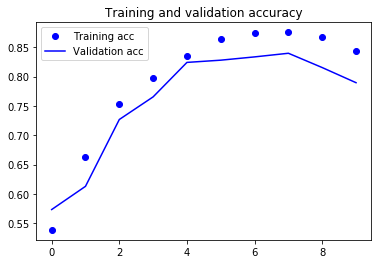

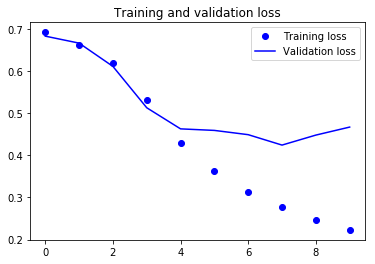

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 结合CNN和RNN来处理长序列

## 数据准备

In [15]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 在耶拿天气数据上训练一个以为卷积神经网络并评估

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=20, validation_data=val_gen, validation_steps=25)

Epoch 1/20
100/100 [==============================] - 3s 34ms/step - loss: 0.4798 - val_loss: 0.3910
Epoch 2/20
100/100 [==============================] - 3s 26ms/step - loss: 0.4280 - val_loss: 0.3417
Epoch 3/20
100/100 [==============================] - 3s 29ms/step - loss: 0.4040 - val_loss: 0.5855
Epoch 4/20
100/100 [==============================] - 3s 28ms/step - loss: 0.3954 - val_loss: 0.4712
Epoch 5/20
100/100 [==============================] - 3s 27ms/step - loss: 0.3829 - val_loss: 0.4860
Epoch 6/20
100/100 [==============================] - 3s 27ms/step - loss: 0.3760 - val_loss: 0.5053
Epoch 7/20
100/100 [==============================] - 3s 29ms/step - loss: 0.3607 - val_loss: 0.6339
Epoch 8/20
100/100 [==============================] - 3s 31ms/step - loss: 0.3584 - val_loss: 0.4914
Epoch 9/20
100/100 [==============================] - 3s 29ms/step - loss: 0.3539 - val_loss: 0.4444
Epoch 10/20
100/100 [==============================] - 3s 30ms/step - loss: 0.3495 - val_lo

## 结果可视化

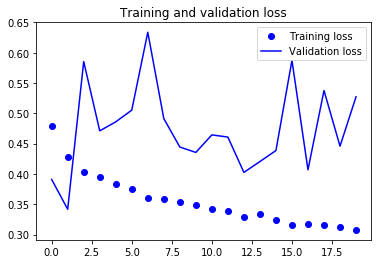

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 为耶拿数据集准备更高分辨率的数据生成器

In [22]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 结合以为卷积基和GRU层的模型

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, validation_data=val_gen, validation_steps=25)

Epoch 1/10
100/100 [==============================] - 55s 549ms/step - loss: 0.3776 - val_loss: 0.3173
Epoch 2/10
100/100 [==============================] - 53s 531ms/step - loss: 0.3403 - val_loss: 0.2898
Epoch 3/10
100/100 [==============================] - 53s 528ms/step - loss: 0.3288 - val_loss: 0.2927
Epoch 4/10
100/100 [==============================] - 53s 527ms/step - loss: 0.3196 - val_loss: 0.2803
Epoch 5/10
100/100 [==============================] - 53s 532ms/step - loss: 0.3169 - val_loss: 0.2936
Epoch 6/10
100/100 [==============================] - 53s 527ms/step - loss: 0.3161 - val_loss: 0.2812
Epoch 7/10
100/100 [==============================] - 53s 534ms/step - loss: 0.3092 - val_loss: 0.2935
Epoch 8/10
100/100 [==============================] - 53s 530ms/step - loss: 0.3070 - val_loss: 0.2745
Epoch 9/10
100/100 [==============================] - 53s 529ms/step - loss: 0.3024 - val_loss: 0.3003
Epoch 10/10
100/100 [==============================] - 53s 532ms/step - l

## 结果可视化

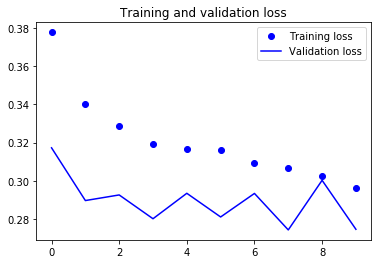

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()